In [1]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.applications import MobileNetV3Large
from tqdm import tqdm

In [2]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 16
IMG_HEIGHT = 192
IMG_WIDTH = 256


#### Defining the two datasets

In [3]:
# cataract dataset
IMG_ROOT = 'dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

In [4]:
OCU_IMG_ROOT='ODIR-5K/Training Images/'
ocu_df=pd.read_excel('ODIR-5K/data.xlsx')

In [5]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

### Process Cataract Dataset

In [6]:
image_folder_normal = 'dataset/1_normal'
image_folder_cataract = 'dataset/2_cataract'
image_paths = []
cataract_labels = []


In [7]:
for filename in os.listdir(image_folder_normal):
    if filename.endswith(".png"):  # Adjust the file extension if needed
        image_paths.append(os.path.join(image_folder_normal, filename))
        cataract_labels.append(0)


In [8]:
for filename in os.listdir(image_folder_cataract):
    if filename.endswith(".png"):  # Adjust the file extension if needed
        image_paths.append(os.path.join(image_folder_cataract, filename))
        cataract_labels.append(1)


In [9]:
data = {'paths': image_paths, 'cataract': cataract_labels}
df = pd.DataFrame(data)


In [10]:
df.to_csv('fundus_images.csv', index=False)


In [11]:
print('Number of normal and cataract images')
print(df['cataract'].value_counts())


Number of normal and cataract images
cataract
0    300
1    100
Name: count, dtype: int64


#### Process Ocular disease recognition dataset

In [12]:
ocu_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [13]:
def has_cataract_mentioned(text):
    if 'cataract' in text:
        return 1
    else:
        return 0
    
ocu_df['left_eye_cataract'] = ocu_df['Left-Diagnostic Keywords'].apply(lambda x: has_cataract_mentioned(x))
ocu_df['right_eye_cataract'] = ocu_df['Right-Diagnostic Keywords'].apply(lambda x: has_cataract_mentioned(x))

In [14]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_cataract']]\
        .rename(columns={'left_eye_cataract':'cataract'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_cataract']]\
        .rename(columns={'right_eye_cataract':'cataract'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [15]:
le_df.head()

,cataract,paths
0,1,ODIR-5K/Training Images/0_left.jpg
1,0,ODIR-5K/Training Images/1_left.jpg
2,0,ODIR-5K/Training Images/2_left.jpg
3,0,ODIR-5K/Training Images/3_left.jpg
4,0,ODIR-5K/Training Images/4_left.jpg


In [16]:
re_df.head()

,cataract,paths
0,0,ODIR-5K/Training Images/0_right.jpg
1,0,ODIR-5K/Training Images/1_right.jpg
2,0,ODIR-5K/Training Images/2_right.jpg
3,0,ODIR-5K/Training Images/3_right.jpg
4,0,ODIR-5K/Training Images/4_right.jpg


In [17]:
print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
cataract
0    3341
1     159
Name: count, dtype: int64

Number of right eye images
cataract
0    3346
1     154
Name: count, dtype: int64


#### Downsampling due to large bias

In [18]:
def downsample(df):
    df = pd.concat([
        df.query('cataract==1'),
        df.query('cataract==0').sample(sum(df['cataract']), 
                                       random_state=SEED)
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['cataract'].value_counts())
print('\nNumber of right eye images')
print(re_df['cataract'].value_counts())

Number of left eye images
cataract
1    159
0    159
Name: count, dtype: int64

Number of right eye images
cataract
1    154
0    154
Name: count, dtype: int64


In [19]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,cataract,paths
0,1,ODIR-5K/Training Images/0_left.jpg
81,1,ODIR-5K/Training Images/81_left.jpg
103,1,ODIR-5K/Training Images/103_left.jpg
119,1,ODIR-5K/Training Images/119_left.jpg
253,1,ODIR-5K/Training Images/254_left.jpg


### Create Datasets

In [20]:
combined_df=pd.concat([df,ocu_df],ignore_index=True)

In [21]:
combined_df.head()

,paths,cataract
0,dataset/1_normal\NL_001.png,0
1,dataset/1_normal\NL_002.png,0
2,dataset/1_normal\NL_003.png,0
3,dataset/1_normal\NL_004.png,0
4,dataset/1_normal\NL_005.png,0


In [22]:
combined_df

,paths,cataract
0,dataset/1_normal\NL_001.png,0
1,dataset/1_normal\NL_002.png,0
2,dataset/1_normal\NL_003.png,0
3,dataset/1_normal\NL_004.png,0
4,dataset/1_normal\NL_005.png,0
...,...,...
1021,ODIR-5K/Training Images/943_right.jpg,0
1022,ODIR-5K/Training Images/2943_right.jpg,0
1023,ODIR-5K/Training Images/3957_right.jpg,0
1024,ODIR-5K/Training Images/199_right.jpg,0


In [23]:
train_df,test_df=train_test_split(combined_df,test_size=0.2,random_state=SEED,stratify=combined_df['cataract'])

train_df,valid_df=train_test_split(train_df,test_size=0.15,random_state=SEED,stratify=train_df['cataract'])

In [24]:
def create_datasets(combined_df,img_width,img_height):
    imgs=[]
    for path in tqdm(combined_df['paths']):
        img=cv2.imread(path)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(img_width,img_height))
        imgs.append(img)
    
    imgs=np.array(imgs,dtype='float32')
    combined_df=pd.get_dummies(combined_df['cataract'])
    return imgs,combined_df

train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, valid_df = create_datasets(valid_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

train_imgs = train_imgs / 255.0
val_imgs = val_imgs / 255.0
test_imgs = test_imgs / 255.0
    

100%|██████████| 206/206 [00:09<00:00, 21.18it/s]


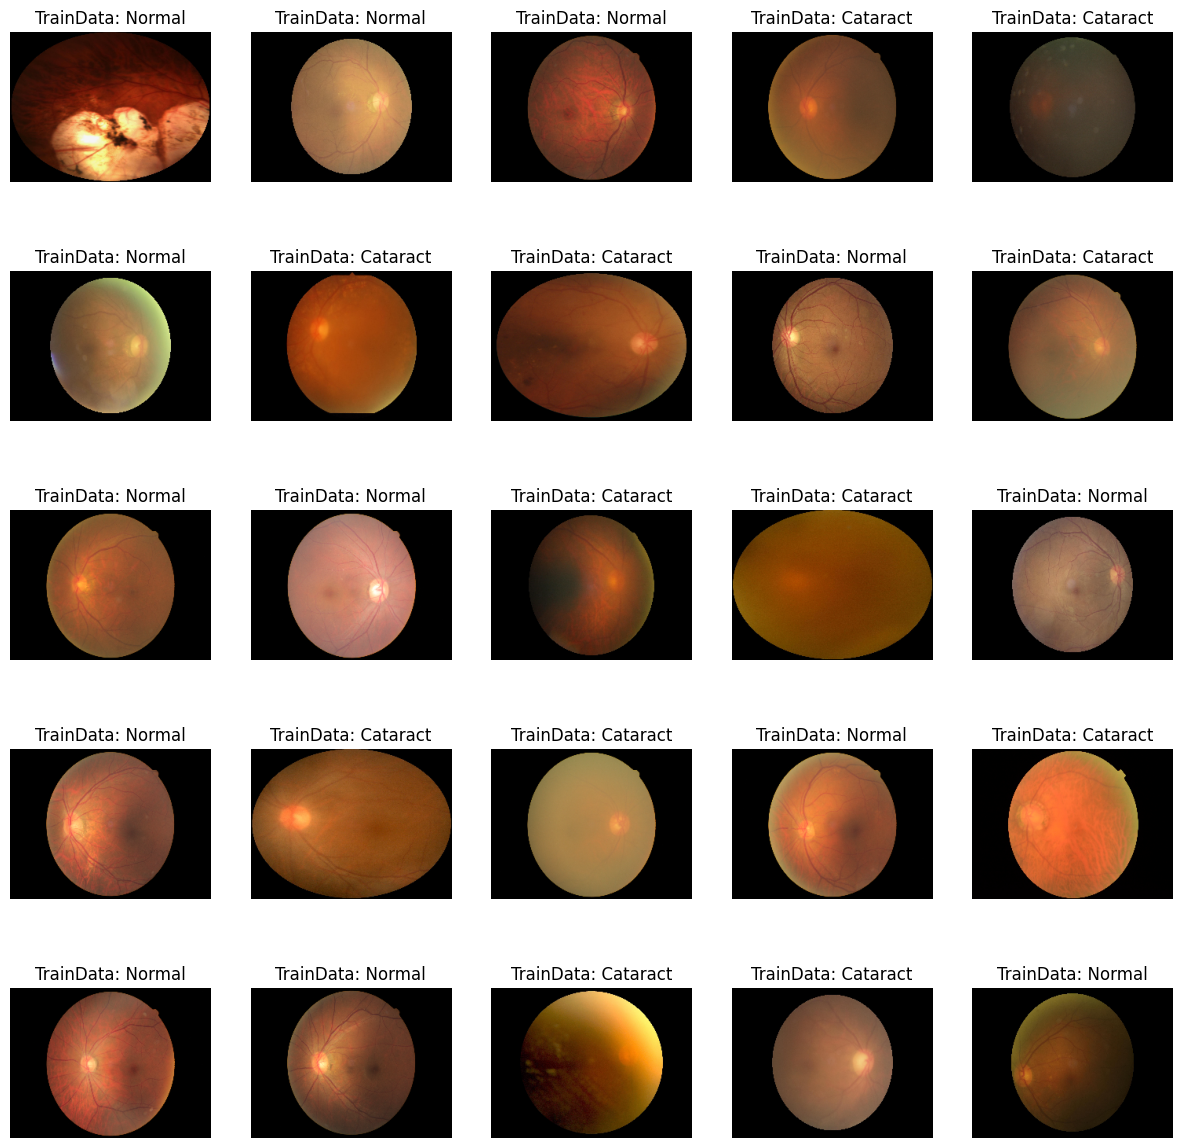

In [25]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Cataract')
plt.show()

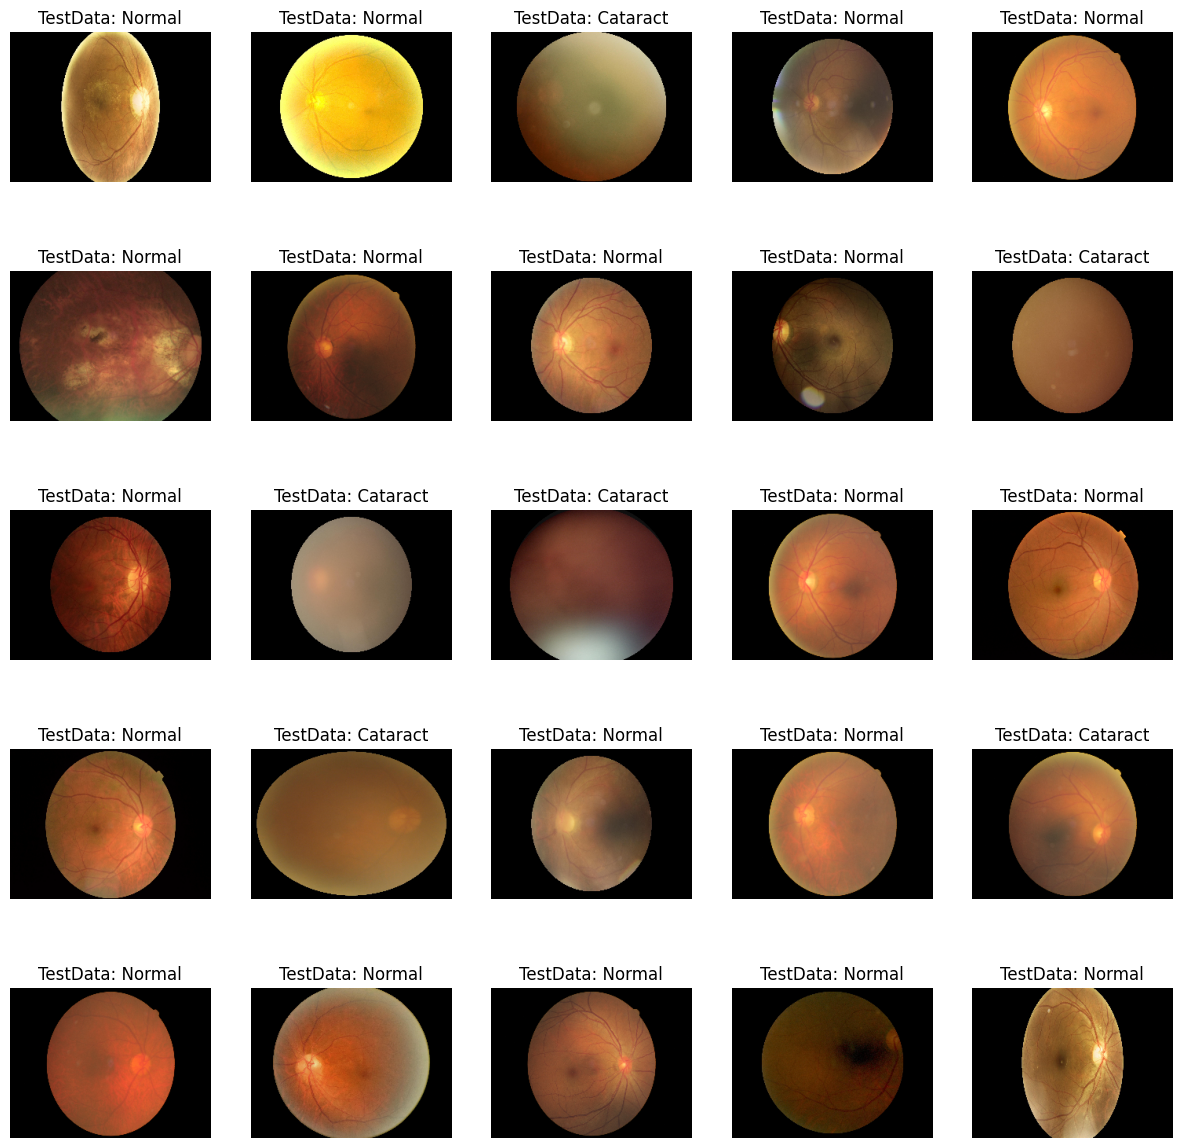

In [26]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Cataract')
plt.show()

In [27]:
from tensorflow.keras.applications import MobileNetV3Large,MobileNetV3Small,ResNet50,InceptionV3
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Dense,Flatten,Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.models import Model,Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [28]:
# Load the MobileNetV3Large model with pre-trained weights (excluding top)
base_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(192, 256,3), pooling='avg')

# Add regularization (L2) to specific layers (e.g., convolutional layers)
l2_lambda = 0.01  # Adjust the strength of L2 regularization as needed

# for layer in base_model.layers:
#     if isinstance(layer, tf.keras.layers.Conv2D):
#         layer.kernel_regularizer = l2(l2_lambda)

# Add a Global Average Pooling layer
x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x=Flatten()(x)
# Add Batch Normalization for regularization and faster convergence
# x = BatchNormalization()(x)

# Add Dropout for regularization (adjust dropout rate as needed)
# dropout_rate = 0.5
# x = Dropout(dropout_rate)(x)

# Add a Dense output layer with softmax activation for classification
num_classes = 2  # Number of classes (severity levels)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the new model
new_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the desired optimizer, loss, and metrics
learning_rate = 0.000003
losses=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
new_model.compile(optimizer=Adam(learning_rate=learning_rate), loss=losses, metrics=['accuracy'])

# Set up callbacks, including ModelCheckpoint, EarlyStopping, and ReduceLROnPlateau
checkpointer = ModelCheckpoint(filepath='drdetection.hdf5', save_best_only=True)
es_callback = EarlyStopping(patience=20, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

# Display the model summary
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 192, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 96, 128, 16)  432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 96, 128, 16)  64         ['Conv[0][0]']               

                                                                                                  
 re_lu_5 (ReLU)                 (None, 48, 64, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 48, 64, 24)  1728        ['re_lu_5[0][0]']                
 D)                                                                                               
                                                                                                  
 expanded_conv_2/project/BatchN  (None, 48, 64, 24)  96          ['expanded_conv_2/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_

                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_10[0][0]']               
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Conv2D)                                                  AvgPool[0][0]']                  
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    0           ['expanded_conv_4/squeeze_excite/
 /Relu (ReLU)                                                    Conv[0][0]']                     
          

                                                                                                  
 expanded_conv_5/Add (Add)      (None, 24, 32, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
                                                                                                  
 expanded_conv_6/expand (Conv2D  (None, 24, 32, 240)  9600       ['expanded_conv_5/Add[0][0]']    
 )                                                                                                
                                                                                                  
 expanded_conv_6/expand/BatchNo  (None, 24, 32, 240)  960        ['expanded_conv_6/expand[0][0]'] 
 rm (BatchNormalization)                                                                          
          

                                                                 Norm[0][0]',                     
                                                                  'tf.math.multiply_7[0][0]']     
                                                                                                  
 expanded_conv_7/project (Conv2  (None, 12, 16, 80)  16000       ['multiply_4[0][0]']             
 D)                                                                                               
                                                                                                  
 expanded_conv_7/project/BatchN  (None, 12, 16, 80)  320         ['expanded_conv_7/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_7/Add (Add)      (None, 12, 16, 80)   0           ['expanded_conv_6/project/BatchNo
          

                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 12, 16, 184)  0          ['expanded_conv_9/depthwise/Batch
 ambda)                                                          Norm[0][0]']                     
                                                                                                  
 re_lu_22 (ReLU)                (None, 12, 16, 184)  0           ['tf.__operators__.add_11[0][0]']
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 12, 16, 184)  0          ['re_lu_22[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_8 (Multiply)          (None, 12, 16, 184)  0           ['expanded_conv_9/depthwise/Batch
          

 expanded_conv_10/project (Conv  (None, 12, 16, 112)  53760      ['expanded_conv_10/squeeze_excite
 2D)                                                             /Mul[0][0]']                     
                                                                                                  
 expanded_conv_10/project/Batch  (None, 12, 16, 112)  448        ['expanded_conv_10/project[0][0]'
 Norm (BatchNormalization)                                       ]                                
                                                                                                  
 expanded_conv_11/expand (Conv2  (None, 12, 16, 672)  75264      ['expanded_conv_10/project/BatchN
 D)                                                              orm[0][0]']                      
                                                                                                  
 expanded_conv_11/expand/BatchN  (None, 12, 16, 672)  2688       ['expanded_conv_11/expand[0][0]']
 orm (Batc

 tf.__operators__.add_18 (TFOpL  (None, 12, 16, 672)  0          ['expanded_conv_12/expand/BatchNo
 ambda)                                                          rm[0][0]']                       
                                                                                                  
 re_lu_29 (ReLU)                (None, 12, 16, 672)  0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 tf.math.multiply_18 (TFOpLambd  (None, 12, 16, 672)  0          ['re_lu_29[0][0]']               
 a)                                                                                               
                                                                                                  
 multiply_13 (Multiply)         (None, 12, 16, 672)  0           ['expanded_conv_12/expand/BatchNo
                                                                 rm[0][0]',                       
          

                                                                                                  
 expanded_conv_13/depthwise/Bat  (None, 6, 8, 960)   3840        ['expanded_conv_13/depthwise[0][0
 chNorm (BatchNormalization)                                     ]']                              
                                                                                                  
 tf.__operators__.add_22 (TFOpL  (None, 6, 8, 960)   0           ['expanded_conv_13/depthwise/Batc
 ambda)                                                          hNorm[0][0]']                    
                                                                                                  
 re_lu_33 (ReLU)                (None, 6, 8, 960)    0           ['tf.__operators__.add_22[0][0]']
                                                                                                  
 tf.math.multiply_22 (TFOpLambd  (None, 6, 8, 960)   0           ['re_lu_33[0][0]']               
 a)       

 multiply_18 (Multiply)         (None, 6, 8, 960)    0           ['expanded_conv_14/depthwise/Batc
                                                                 hNorm[0][0]',                    
                                                                  'tf.math.multiply_25[0][0]']    
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 960)   0           ['multiply_18[0][0]']            
 e/AvgPool (GlobalAveragePoolin                                                                   
 g2D)                                                                                             
                                                                                                  
 expanded_conv_14/squeeze_excit  (None, 1, 1, 240)   230640      ['expanded_conv_14/squeeze_excite
 e/Conv (Conv2D)                                                 /AvgPool[0][0]']                 
          

In [29]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 

Epoch 1/100
43/43 [==============================] - 20s 197ms/step - loss: 0.6555 - accuracy: 0.6255 - val_loss: 0.6508 - val_accuracy: 0.6260 - lr: 3.0000e-06
Epoch 2/100
43/43 [==============================] - 5s 113ms/step - loss: 0.5474 - accuracy: 0.7403 - val_loss: 0.6480 - val_accuracy: 0.6341 - lr: 3.0000e-06
Epoch 3/100
43/43 [==============================] - 5s 112ms/step - loss: 0.4868 - accuracy: 0.7805 - val_loss: 0.6515 - val_accuracy: 0.6260 - lr: 3.0000e-06
Epoch 4/100
43/43 [==============================] - 5s 118ms/step - loss: 0.4400 - accuracy: 0.8164 - val_loss: 0.6502 - val_accuracy: 0.6260 - lr: 3.0000e-06
Epoch 5/100
43/43 [==============================] - 5s 116ms/step - loss: 0.3911 - accuracy: 0.8451 - val_loss: 0.6488 - val_accuracy: 0.6341 - lr: 3.0000e-06
Epoch 6/100
43/43 [==============================] - 5s 115ms/step - loss: 0.3743 - accuracy: 0.8709 - val_loss: 0.6471 - val_accuracy: 0.6341 - lr: 3.0000e-06
Epoch 7/100
43/43 [====================

Epoch 49/100
44/43 [==============================] - ETA: 0s - loss: 0.2559 - accuracy: 0.9211
Epoch 49: ReduceLROnPlateau reducing learning rate to 3.000000248221113e-10.
43/43 [==============================] - 6s 128ms/step - loss: 0.2559 - accuracy: 0.9211 - val_loss: 0.6539 - val_accuracy: 0.6585 - lr: 3.0000e-09
Epoch 50/100
43/43 [==============================] - 6s 125ms/step - loss: 0.2550 - accuracy: 0.9082 - val_loss: 0.6560 - val_accuracy: 0.6504 - lr: 3.0000e-10
Epoch 51/100
43/43 [==============================] - 6s 126ms/step - loss: 0.2413 - accuracy: 0.9096 - val_loss: 0.6594 - val_accuracy: 0.6423 - lr: 3.0000e-10
Epoch 52/100
43/43 [==============================] - 6s 126ms/step - loss: 0.2513 - accuracy: 0.9110 - val_loss: 0.6642 - val_accuracy: 0.6585 - lr: 3.0000e-10
Epoch 53/100
43/43 [==============================] - 6s 128ms/step - loss: 0.2471 - accuracy: 0.9096 - val_loss: 0.6760 - val_accuracy: 0.6179 - lr: 3.0000e-10
Epoch 54/100
43/43 [===============

Epoch 95/100
43/43 [==============================] - 6s 128ms/step - loss: 0.2513 - accuracy: 0.9024 - val_loss: 1.6870 - val_accuracy: 0.3984 - lr: 3.0000e-14
Epoch 96/100
43/43 [==============================] - 6s 139ms/step - loss: 0.2469 - accuracy: 0.9053 - val_loss: 1.7041 - val_accuracy: 0.3984 - lr: 3.0000e-14
Epoch 97/100
43/43 [==============================] - 6s 138ms/step - loss: 0.2826 - accuracy: 0.8895 - val_loss: 1.7150 - val_accuracy: 0.3984 - lr: 3.0000e-14
Epoch 98/100
43/43 [==============================] - 6s 134ms/step - loss: 0.2554 - accuracy: 0.8996 - val_loss: 1.7227 - val_accuracy: 0.3984 - lr: 3.0000e-14
Epoch 99/100
44/43 [==============================] - ETA: 0s - loss: 0.2484 - accuracy: 0.9067
Epoch 99: ReduceLROnPlateau reducing learning rate to 3.000000286168189e-15.
43/43 [==============================] - 6s 131ms/step - loss: 0.2484 - accuracy: 0.9067 - val_loss: 1.7290 - val_accuracy: 0.3984 - lr: 3.0000e-14
Epoch 100/100
43/43 [==============

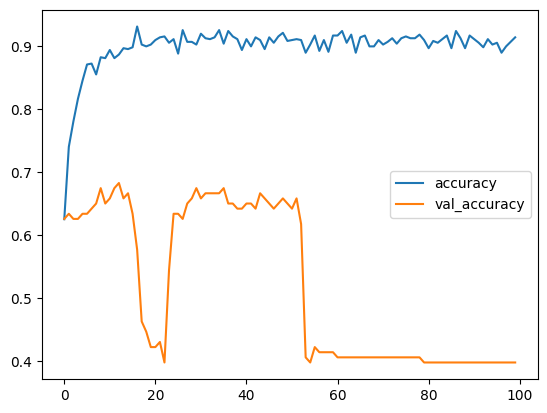

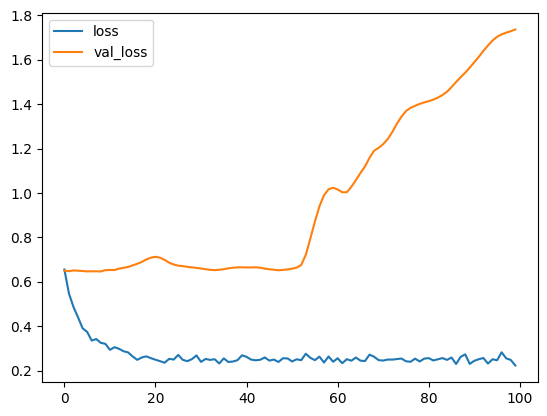

In [30]:
# Set the number of epochs you want to train for
epochs = 50  # You can adjust this number based on your requirements

history = new_model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[reduce_lr],
                    validation_data=(val_imgs, valid_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [1]:
new_model.evaluate(test_imgs, test_df) 

NameError: name 'new_model' is not defined